In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, Input, GlobalMaxPool1D
from tensorflow.keras.layers import LSTM, Embedding
from tensorflow.keras.models import Model

In [3]:
 import os
 os.chdir("/content/drive/MyDrive/NLP/Sentiment_Analysis_with_NLTK")

In [4]:
# Reading the dataset
df = pd.read_csv('/content/drive/MyDrive/NLP/Sentiment_Analysis_with_NLTK/spam.csv', encoding = 'ISO-8859-1')

In [5]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


# Data Preprocessing

In [6]:
# drop unsued columns
df = df.drop(['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], axis = 1)

In [7]:
df.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [8]:
# rename columns
df.columns = ['labels', 'data']

In [9]:
df.head()

,labels,data
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# create binary labels (0 and 1)
df['binary_labels'] = df['labels'].map({'ham': 0, 'spam': 1})
y = df['binary_labels'].values

In [11]:
print(y)

[0 0 1 ... 0 0 0]


In [12]:
# split the data into train and test
x_train, x_test, y_train, y_test = train_test_split(df['data'], y, test_size=0.33)

In [13]:
# convert sentences into sequence
max_vocab_size = 2000
tokenizer = Tokenizer(num_words=max_vocab_size)
tokenizer.fit_on_texts(x_train)
sequence_train = tokenizer.texts_to_sequences(x_train)
sequence_test = tokenizer.texts_to_sequences(x_test)

In [14]:
# check word index mapping (to check the number of words in the vocabulary)
word2idex = tokenizer.word_index
v = len(word2idex)
print('Total number of unique token sentences are: %s' % v)

Total number of unique token sentences are: 7232


In [15]:
#pad sequences (to get N*T matrix)
data_train = pad_sequences(sequence_train)

In [16]:
print('Shape of data train tensor:', data_train.shape)

Shape of data train tensor: (3733, 173)


In [17]:
# set the value of T to get sequence length
T = data_train.shape[1]

In [18]:
print(T)

173


In [19]:
# pad the test set
data_test = pad_sequences(sequence_test, maxlen=T)
# maxlen = T to truncate longer sentences in test set
print('Shape of data test tensor:', data_test.shape)

Shape of data test tensor: (1839, 173)


# Model Building

In [20]:
# choose embedding dimensionality
d = 20

# hidden state vetorsize

m = 15

input_shape = (T, )

# input layer
i = Input(shape = input_shape) # input layer takes in sequences of integers and, so shape is T

#Embedding layer
x = Embedding(v+1, d)(i) # This takes in sequence of of integers and returns sequences of word vectors. This will be an N*T*D array
# We want size of embedding to (v+1)*d, because first word index starts from 1 and not 0

#LSTM layer
x = LSTM(m, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)

#Dense layer
x = Dense(1, activation='sigmoid')(x) # we are using sigmoid since it is a binary classification problem

model = Model(i, x)


In [21]:
# model compilation

model.compile(optimizer = 'adam', loss='binary_crossentropy', metrics=['accuracy'])

In [22]:
# Train model

r = model.fit(x = data_train, y = y_train, epochs = 10, validation_data=(data_test, y_test))

Epoch 1/10
117/117 [==============================] - 17s 118ms/step - loss: 0.4685 - accuracy: 0.8604 - val_loss: 0.3692 - val_accuracy: 0.8651
Epoch 2/10
117/117 [==============================] - 6s 54ms/step - loss: 0.2903 - accuracy: 0.8663 - val_loss: 0.2184 - val_accuracy: 0.8651
Epoch 3/10
117/117 [==============================] - 3s 27ms/step - loss: 0.1712 - accuracy: 0.9654 - val_loss: 0.1501 - val_accuracy: 0.9744
Epoch 4/10
117/117 [==============================] - 3s 26ms/step - loss: 0.1143 - accuracy: 0.9871 - val_loss: 0.1036 - val_accuracy: 0.9826
Epoch 5/10
117/117 [==============================] - 3s 25ms/step - loss: 0.0734 - accuracy: 0.9920 - val_loss: 0.0784 - val_accuracy: 0.9837
Epoch 6/10
117/117 [==============================] - 2s 16ms/step - loss: 0.0523 - accuracy: 0.9946 - val_loss: 0.0668 - val_accuracy: 0.9864
Epoch 7/10
117/117 [==============================] - 2s 17ms/step - loss: 0.0400 - accuracy: 0.9957 - val_loss: 0.0611 - val_accuracy: 0.98

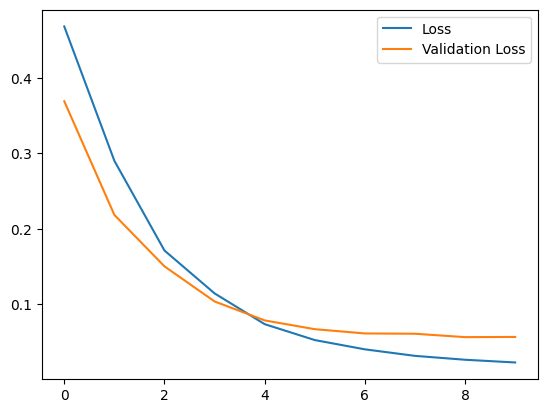

In [24]:
# Loss per iteration
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

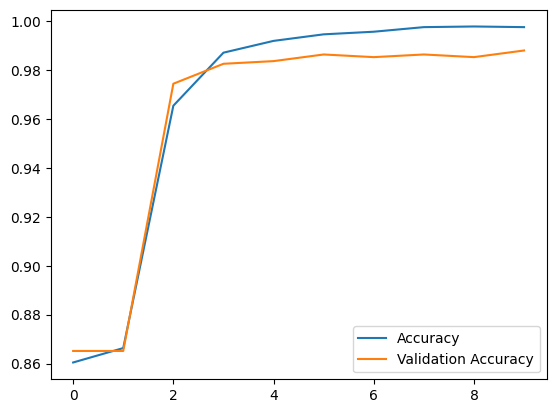

In [25]:
# Accuracy per iteration
plt.plot(r.history['accuracy'], label='Accuracy')
plt.plot(r.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()